In [1]:
# 1. 데이터 불러오기 및 전처리
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# [1-1] 데이터프레임으로 불러오기
df = pd.read_excel('서울대기오염_2019.xlsx')

In [5]:
# [1-2] 컬럼명 변경
# 필요한 4개 컬럼만 추출
df = df[['날짜', '측정소명', '미세먼지', '초미세먼지']].copy()

# 컬럼명 영문으로 변경
df.columns = ['date', 'district', 'pm10', 'pm25']


In [6]:
# [1-3] 결측치 및 이상치 처리
print("원본 결측치 수:\n", df.isnull().sum())

# 도메인 기준 이상치 제거 (예: pm10 > 600 제거)
df = df[df['pm10'] <= 600]

# 결측치 제거 (또는 평균/중앙값 대체 가능)
df.dropna(subset=['pm10', 'pm25'], inplace=True)

원본 결측치 수:
 date          0
district      0
pm10        213
pm25        203
dtype: int64


In [8]:
# [1-4] 자료형 변환
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
df = df[df['date'].notnull()]  # 날짜 변환 실패 행 제거

df['pm10'] = df['pm10'].astype(float)
df['pm25'] = df['pm25'].astype(float)


In [9]:
# [2-1] month, day
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [10]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'
    

df['season'] = df['month'].apply(get_season)

In [12]:
# 3. 데이터 확인 및 저장
df.to_csv('card_output.csv', index=False)

In [13]:
# 4. 연간 평균
overall_avg = df['pm10'].mean()
print("연간 평균 PM10:", overall_avg)

연간 평균 PM10: 41.76412139539907


In [14]:
# 5. PM10 최댓값 발생 일자 및 지역
max_row = df.loc[df['pm10'].idxmax()]
print("최댓값 일자 및 구:", max_row['date'], max_row['district'])

최댓값 일자 및 구: 2019-03-05 00:00:00 강북구


In [15]:
# 6. 구별 PM10 평균 상위 5개
district_avg = df.groupby('district')['pm10'].mean().sort_values(ascending=False).head(5)
print("구별 평균 PM10 상위 5개:\n", district_avg)

구별 평균 PM10 상위 5개:
 district
관악구    49.083601
양천구    47.695055
마포구    47.086154
강서구    46.504132
강북구    44.950685
Name: pm10, dtype: float64


In [16]:
#  7. 계절별 PM10/PM25 평균
df_season = df.groupby('season')[['pm10', 'pm25']].mean().sort_values(by='pm10')
print(df_season)

             pm10       pm25
season                      
summer  26.321307  18.087861
autumn  31.118349  15.703211
spring  54.088629  31.558110
winter  54.681682  33.660232


In [19]:
# 8. PM10 등급화 및 분포

def pm_grade(value):
    if value <= 30:
        return 'good'
    elif value <= 80:
        return 'normal'
    elif value <= 150:
        return 'bad'
    else:
        return 'worse'

df['pm_grade'] = df['pm10'].apply(pm_grade)

pm_dist = df['pm_grade'].value_counts().reset_index()
pm_dist.columns = ['pm_grade', 'n']
pm_dist['pct'] = round(pm_dist['n'] / len(df) * 100, 2)
print(pm_dist)

  pm_grade     n    pct
0   normal  5005  54.06
1     good  3543  38.27
2      bad   627   6.77
3    worse    84   0.91


In [20]:
# 9. 구별 good 비율 상위 5개
good_ratio = (
    df[df['pm_grade'] == 'good']
    .groupby('district')['pm_grade']
    .count()
    .reset_index(name='n')
)

total_by_district = df.groupby('district')['pm_grade'].count().reset_index(name='total')
good_pct = pd.merge(good_ratio, total_by_district, on='district')
good_pct['pct'] = round(good_pct['n'] / good_pct['total'] * 100, 2)

print(good_pct.sort_values(by='pct', ascending=False).head(5))

   district    n  total    pct
20      용산구  196    363  53.99
23       중구  169    365  46.30
24      중랑구  150    326  46.01
22      종로구  162    364  44.51
9       도봉구  162    365  44.38


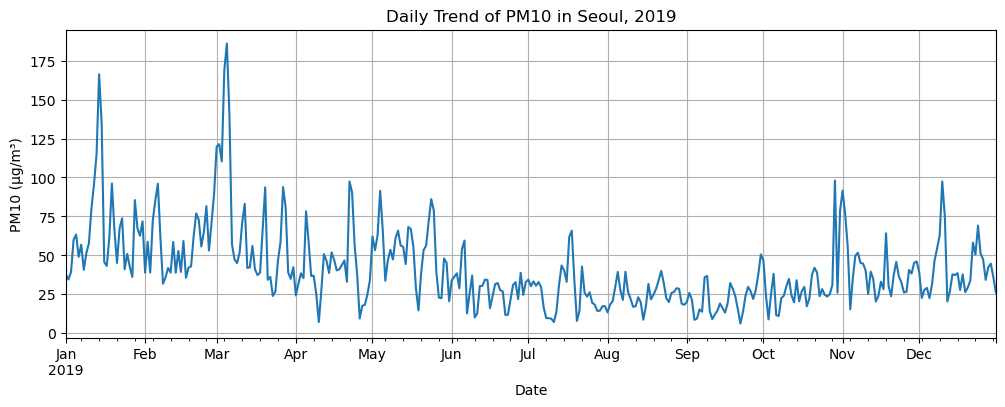

In [21]:
# 10. 일별 PM10 추이 그래프
plt.figure(figsize=(12, 4))
df.groupby('date')['pm10'].mean().plot()
plt.title('Daily Trend of PM10 in Seoul, 2019')
plt.xlabel('Date')
plt.ylabel('PM10 (μg/m³)')
plt.grid()
plt.show()

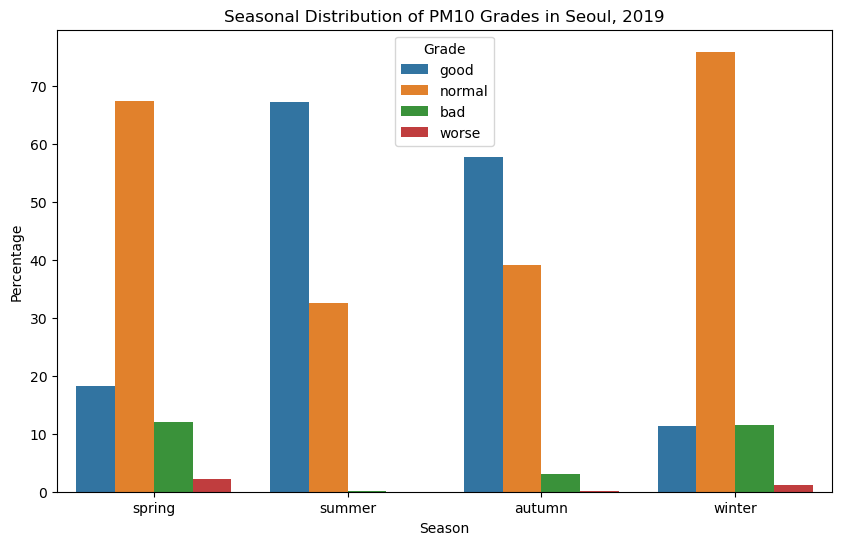

In [22]:
# 11. 계절별 등급 비율 그래프
season_grade = (
    df.groupby(['season', 'pm_grade'])
    .size()
    .reset_index(name='n')
)

total_season = season_grade.groupby('season')['n'].transform('sum')
season_grade['pct'] = round(season_grade['n'] / total_season * 100, 2)

plt.figure(figsize=(10, 6))
sns.barplot(data=season_grade, x='season', y='pct', hue='pm_grade', order=['spring', 'summer', 'autumn', 'winter'], hue_order=['good', 'normal', 'bad', 'worse'])
plt.title('Seasonal Distribution of PM10 Grades in Seoul, 2019')
plt.ylabel('Percentage')
plt.xlabel('Season')
plt.legend(title='Grade')
plt.show()